<a href="https://colab.research.google.com/github/dafran/datascienceIbero/blob/main/ProyectoBootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contexto de negocio**


Actualmente trabajo en una empresa aliada a una importante empresa de telecomunicaciones en Estados Unidos. Especificamente manejamos las ordenes de venta de servicios de telecomunicaciones (internet, telefonia). Cuando un vendendor de esa empresa coloca una venta, nos envian los datos para hacer seguimiento de que se haga la colocación de la venta y que se realice la instalación del servicio de forma adecuada y en los tiempos previstos. 

Sin embargo, no todas las ordenes de colocación de producto son válidas, pues se ha evidenciado que algunas no tienen la aprobación del cliente, no hay información valida del comprador o no existen en el sistema del proveedor. 

**Ante esta situación se propone realizar modelos supervizados para tratar de identificar las ordenes que terminaran con un estatus de cancelada o invalidas.** 
Evidentemente, esto representa un problema para la operación, pues los agentes llevan en su carga operativa ordenes que nunca debieron colocarse o que terminan cancelandose por situaciones que se salen de su control. 

Para esto, es necesario que se empleen diversas tecnicas para predcir la cancelación de una orden. Para esto, se plantea emplear las notas que dejan los agentes durante el ciclo de vida de la orden. Estas notas, no están clasificadas y son de texto completamente abierto, por lo que su análisis amerita de técnicas avanzadas de procesamiento natural de lenguaje (NLP).

# **Descripción de los datos**

Para hacer el análisis se trabajará con datos de las interacciones que realizan los agentes que no están categorizadas, de nombre **"comentarios diarios"**. Estos comentarios representan anotaciones particulares que realiza el agente con sus apreciaciones sobre el estado de la orden. Además, generalmente no implican interacciones con cliente o vendedor, que según los análisis realizados anteriormente, no ayudan a diferenciar una orden invalida de una cancelada. 

Es importante tener en cuenta que una orden puede tener mas de un comentario diario durante su ciclo de vida. 

Adicionalmente para el análisis se tomará en cuenta solamente las órdenes que se hayan cerrado en el año 2021, debido a que los procesos operativos de los años anteriores difieren mucho. Además, se tomarán las ordenes del producto AB, que representan el porcentaje mayoritario del negocio y es prioridad para la operadora.


In [1]:
!pip install boto3
import pandas as pd
from sqlalchemy import insert, create_engine,Table, MetaData,select, Column,Integer,String,ForeignKey,Float,Date,extract,update,DateTime,Boolean,cast,and_,or_,func
from sqlalchemy.orm import sessionmaker,relationship
import traceback
import datetime
#import win32com
from sqlalchemy import cast, Date
import boto3
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, average_precision_score
!pip install xgbfir
import xgbfir
import glob
from datetime import datetime
from matplotlib import pyplot
import re
from numpy import loadtxt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from boto3.session import Session
!pip install awswrangler
import awswrangler as wr

In [2]:
#LLaves
import getpass
aws_access_key_id = getpass.getpass("AWS_ACCESS_KEY_ID: ")
aws_secret_access_key = getpass.getpass("AWS_SECRET_ACCESS_KEY: ")



AWS_ACCESS_KEY_ID: ··········
AWS_SECRET_ACCESS_KEY: ··········


In [3]:
session = Session(aws_access_key_id=aws_access_key_id,aws_secret_access_key=aws_secret_access_key,region_name="us-east-1")
s3 = boto3.client('s3',aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

In [4]:
orders = wr.athena.read_sql_query(
sql="""
 select order_id, project_status_name, closed_date,cancelcodes, prodreclass, dur, experience, experience_seller, pm_seller_exp, cc, uc, oc, totalcalls
 from sm_daily_complete
 where team <> 'Blue Team (Fairness)' and project_status_name not in ('Open', 'Reassigned', 'New','Closed - Rebid') ; 
  """,
    database="e2e-nest",
    boto3_session= session
)

In [5]:
orders['month'] = pd.DatetimeIndex(orders['closed_date']).month
orders['year'] = pd.DatetimeIndex(orders['closed_date']).year

In [6]:
orders = orders.drop(orders[orders.year == 2021].index)

In [7]:
orders['status'] = orders['cancelcodes'].replace(['Cancel-ReorderSysIssue','CancelDuplicate','CancelPre-ReceivedCancel','CancelWrongInfo','Rejected-WorkedbyOtherDep',
                                                  'Cancel-ForceMajeure', 'Cancel-RSCDisengagedStale','CancelPos-ByOtherDep', 'CancelPos-CxNoLongerWants',
                                                  'CancelPos-CxWent2Competit','CancelPos-FacilitiesIssue', 'CancelPos-InstallIssue', 'CancelPos-NoRespOrReason',
                                                  'CancelPos-NoSale','CancelPos-WiringIssues','CancelPre-CxNeverApproved',""],
                                                 ['Invalid','Invalid','Invalid','Invalid','Invalid', 'Cancelled','Cancelled','Cancelled','Cancelled',
                                                  'Cancelled','Cancelled','Cancelled','Cancelled','Cancelled','Cancelled','Cancelled','Completed'])


In [8]:
orders.groupby('project_status_name').size()

project_status_name
Cancelled     9679
Completed    24311
dtype: int64

Para el analisis se toma una cantidad de 24mil ordenes completadas y 9mil canceladas.

In [9]:
orders.groupby('status').size()

status
Cancelled     6867
Completed    24307
Invalid       2816
dtype: int64

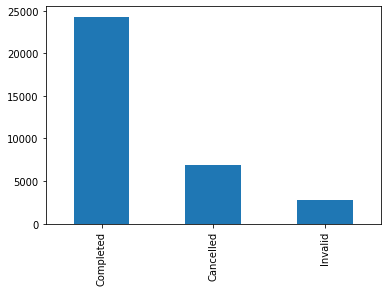

In [10]:
orders['status'].value_counts().plot.bar()

Estas se reclasifican según los codigos de cancelacion, para separar las ordenes canceladas de las invalidas. De esta forma se trabajará con 6800 ordenes canceladas, 2800 invalidas y 24 mil completadas.

In [10]:
orders.head()

,order_id,project_status_name,closed_date,cancelcodes,prodreclass,dur,experience,experience_seller,pm_seller_exp,cc,uc,oc,totalcalls,month,year,status
0,5942515444,Cancelled,2020-12-11 13:11:00,CancelPos-CxNoLongerWants,ABF,16,48,61,7,0,0,3,3,12,2020,Cancelled
11,5935913524,Completed,2020-12-15 08:41:00,,ABF,18,39,27,4,1,1,0,2,12,2020,Completed
18,1016077201,Cancelled,2020-06-09 09:49:00,CancelPos-CxNoLongerWants,ADI,13,249,21,2,0,0,0,1,6,2020,Cancelled
19,4248728235,Cancelled,2020-06-16 18:55:00,CancelPre-ReceivedCancel,ABF,2,649,22,12,0,0,1,1,6,2020,Invalid
26,1016000727,Completed,2020-07-01 15:15:00,,ADI,47,83,16,2,1,1,0,4,7,2020,Completed


In [11]:
orders.groupby(['prodreclass','status']).size()

prodreclass  status   
ABF          Cancelled     4590
             Completed    15073
             Invalid       1682
ADI          Cancelled     2277
             Completed     9234
             Invalid       1134
dtype: int64

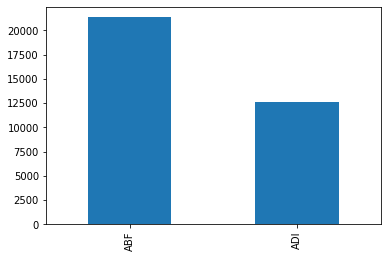

In [11]:
orders['prodreclass'].value_counts().plot.bar()

Adicionalmente, se trabajaran con poductos ADI y ABF, que tienen 12mil  y 21mil casos respectivamente. Sin embnargo, esta cantidad se verá reducida pues no todas las ordenes tienen comentarios diarios. Para esto se traerá la información necesaria de la tabla de interacciones. 

In [12]:
interactions = wr.athena.read_sql_query(
sql="""
 select 
 order_id,event, event_description, interaction_date
 from last_interactions
 where event like 'Day Summary Notes%'; 
  """,
    database="e2e-nest",
    boto3_session= session
)

In [ ]:
interactions.shape

(33513, 4)

In [13]:
df = pd.merge(orders,interactions,how='inner',on='order_id')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10239 entries, 0 to 10238
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             10239 non-null  string        
 1   project_status_name  10239 non-null  string        
 2   closed_date          10239 non-null  datetime64[ns]
 3   cancelcodes          10239 non-null  string        
 4   prodreclass          10239 non-null  string        
 5   dur                  10239 non-null  Int64         
 6   experience           10239 non-null  Int64         
 7   experience_seller    10239 non-null  Int64         
 8   pm_seller_exp        10239 non-null  Int64         
 9   cc                   7783 non-null   Int64         
 10  uc                   7783 non-null   Int64         
 11  oc                   7783 non-null   Int64         
 12  totalcalls           7783 non-null   Int64         
 13  month                10239 non-

In [15]:
df.groupby(['prodreclass','status']).size()

prodreclass  status   
ABF          Cancelled    1485
             Completed    2838
             Invalid       700
ADI          Cancelled    1142
             Completed    3527
             Invalid       547
dtype: int64

In [12]:
import seaborn as sns

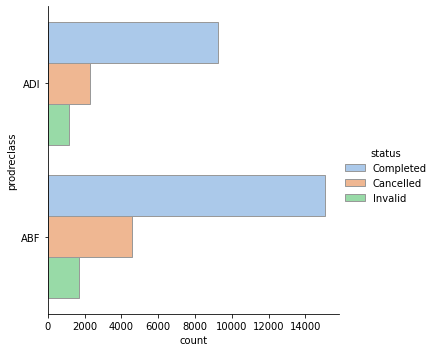

In [13]:
sns.catplot(y="prodreclass", hue="status", kind="count",
            palette="pastel", edgecolor=".6",
            data=orders)

Tras hacer el cruce de información, se trabajará con 5mil casos de ABF y 5mil casos de ADI. 

In [16]:
df.nunique(axis=0)

order_id               10239
project_status_name        2
closed_date             9920
cancelcodes               15
prodreclass                2
dur                      452
experience              1437
experience_seller        272
pm_seller_exp            164
cc                        16
uc                        14
oc                        17
totalcalls                31
month                     12
year                       1
status                     3
event                   6891
event_description       6891
interaction_date       10235
dtype: int64

Finalmente, para este trabajo se empleará solo informacion del año 2021, de dos productos especificos. A continuación se realizarán los procesos de limpieza de la data del campo de texto, de nombre 'event'.

# **Limpieza del texto**

In [17]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 8.3 MB/s 


In [18]:
from spellchecker import SpellChecker
import nltk # importar natural language toolkit
nltk.download('punkt') 
nltk.download('stopwords') # modulo para descargar stopwords en diferentes idiomas
import pandas as pd
import numpy  as np
import string
import plotly
from nltk.stem import PorterStemmer 
from time import time
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Para hacer la limpieza del texto se descargará el diccionario de stopwords en ingles. 

In [19]:
stop_words = stopwords.words('english')

A este listado se le eliminarán las palabtas de negación, pues son importantes mantenerlas para el contexto en el que se trabajará. Esto debido a que la negacion es importante para indicar cuando algo no anda bien en comunicación o en otros aspectos de la orden.

In [20]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
stop_words.remove('no')
stop_words.remove('nor')
stop_words.remove('not')

In [22]:
import time
start_time = time.time()
df['event2']=df['event'][0:len(df['event'])].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#df['event2']= [w for w in df['event'] if not w.lower() in stop_words]
print("---El tiempo para remover las stopwords fue de: %s seconds ---" % (time.time() - start_time))

---El tiempo para remover las stopwords fue de: 0.4267573356628418 seconds ---


Adicionalmente se debe eliminar el texto "Day Summary Notes" del tipo de interacción que se realiza, pues como todas las interacciones la tienen, terminará sesgando alguno de los resultados.

In [23]:
df['event2'] = df['event2'].str.replace(r'Day Summary Notes/','')

Luego de hacer ambos procesos, se encuentra el resultado siguiente:

In [24]:
df[['event','event2']]

,event,event2
0,Day Summary Notes/ Order has been fully cancel...,Order fully canceled. Closed order.
1,"Day Summary Notes/ ""CANCEL"", Email received fr...","""CANCEL"", Email received Seller: Can please c..."
2,Day Summary Notes/ Job ID issue,Job ID issue
3,Day Summary Notes/ Still no updates,Still no updates
4,Day Summary Notes/ order completed,order completed
...,...,...
10234,Day Summary Notes/ Completed: Seller and custo...,Completed: Seller customer advised.
10235,Day Summary Notes/ dispatch,dispatch
10236,Day Summary Notes/ Jeanette scheduled install ...,Jeanette scheduled install 07-03
10237,Day Summary Notes/ order completed.,order completed.


Por otro lado tambien se procede a eliminar signos de puntuación, tildes o simbolos que podrian ser un problema para el procesamiento que se realizará.

In [25]:
# Función Limpieza de caracteres especiales, puntuacion, caracteres alfa-númericos y espacios o new lines
X = df['event2']
start_time = time.time()
import re
corpus = []
for i in range(0, len(X)):
  try:
    review = re.sub('\[.*?¿\]\%', ' ',str(X[i])) #remover caracteres especiales
    review = review.lower() # Poner en minisculas todo el documento
    review = re.sub('[%s]' % re.escape(string.punctuation), ' ',review) #remover puntuación
    review = re.sub('\w*\d\w*', '',review) #remover números entre palabras
    review = re.sub(r'\b(\w+)( \1\b)+', r'\1', review) #remover palabras duplicadas consecutivas
    review = re.sub(r',', '', review) # Remover comas
    review = re.sub(r'\-', ' ', review) # Remover guiones
    review = re.sub(r'á', 'a', review) # remover tildes
    review = re.sub(r'é', 'e', review) # remover tildes
    review = re.sub(r'í', 'i', review) # remover tildes
    review = re.sub(r'ó', 'o', review) # remover tildes
    review = re.sub(r'ú', 'u', review) # remover tildes
    #review = re.sub('\[.*?¿\]\%', ' ',review) #remover caracteres especiales
    #word = review.lower() # Poner en minisculas todo el documento
    #review = re.sub('\w*\d\w*', '',review) #remover números entre palabras
    review = re.sub('[‘’“”…«»]', '',review)#remover caracteres adicionales
    review = re.sub('\n', ' ',review) #remover newlines
    corpus.append(review)  
  except:
    pass
print("---El tiempo para proceso de limpieza fue de :%s seconds ---" % (time.time() - start_time))

---El tiempo para proceso de limpieza fue de :0.4055478572845459 seconds ---


In [26]:
corpus

[' order fully canceled  closed order ',
 '  cancel   email received seller  can please cancel order  the customer changed mind  called live reschedule line  new appointment date setup    avoid unnecessary truck roll  as per seller s email received  client changed mind   cancelling order   email replied back seller  rds    submitted  order received imminent cancellation  ',
 ' job id issue',
 ' still no updates',
 ' order completed',
 ' preinstall date not working',
 ' left vm sent email',
 ' multiple call ',
 '   order cancel customer never ordered service someone used the managers information to create a fake install as a joke and the sales agent let it go through  notified  about the jep  there is no install at this location they already have internet ',
 '   uvf     order not correct  customer wanted upgrade  no voip new order  notified manager ',
 ' upgrade order complete',
 ' order cancelled ios',
 '     customer wants cancel order  speed offered low landlord advised att service 

In [27]:
X

0                      Order fully canceled. Closed order.
1         "CANCEL", Email received Seller: Can please c...
2                                             Job ID issue
3                                         Still no updates
4                                          order completed
                               ...                        
10234                  Completed: Seller customer advised.
10235                                             dispatch
10236                     Jeanette scheduled install 07-03
10237                                     order completed.
10238              EAD ECD 08/13. Michael already informed
Name: event2, Length: 10239, dtype: object

In [28]:
import time
start_time = time.time()
import re

def pre_process(text):
    text=text.lower()
    text = re.sub('\[.*?¿\]\%', ' ',text) #remover caracteres especiales
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text) #remover puntuación
    text = re.sub('\w*\d\w*', '',text) #remover números entre palabras
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) #remover palabras duplicadas consecutivas
    text = re.sub(r',', '', text) # Remover comas
    text = re.sub(r'\-', ' ', text) # Remover guiones
    text = re.sub(r'á', 'a', text) # remover tildes
    text = re.sub(r'é', 'e', text) # remover tildes
    text = re.sub(r'í', 'i', text) # remover tildes
    text = re.sub(r'ó', 'o', text) # remover tildes
    text = re.sub(r'ú', 'u', text) # remover tildes
    text = re.sub('\[.*?¿\]\%', ' ',text) #remover caracteres especiales
    #word = review.lower() # Poner en minisculas todo el documento
    text = re.sub('\w*\d\w*', '',text) #remover números entre palabras
    text = re.sub('[‘’“”…«»]', '',text)#remover caracteres adicionales
    text = re.sub('\n', ' ',text) #remover newlines    
    return text

#data['sueno'] = data['sueno'].apply(lambda x:pre_process(x))  
df['event2'] = df['event2'].apply(lambda x:pre_process(x))  
print("---El tiempo para proceso de limpieza fue de :%s seconds ---" % (time.time() - start_time))

#Mostra el segundo registro para ver como se realizo el proceso 
#data['sueno'][0]
df['event2'][0]

---El tiempo para proceso de limpieza fue de :0.44971251487731934 seconds ---


' order fully canceled  closed order '

El resultado del proceso es el siguiente:

In [29]:
df[['event','event2']]

,event,event2
0,Day Summary Notes/ Order has been fully cancel...,order fully canceled closed order
1,"Day Summary Notes/ ""CANCEL"", Email received fr...",cancel email received seller can please c...
2,Day Summary Notes/ Job ID issue,job id issue
3,Day Summary Notes/ Still no updates,still no updates
4,Day Summary Notes/ order completed,order completed
...,...,...
10234,Day Summary Notes/ Completed: Seller and custo...,completed seller customer advised
10235,Day Summary Notes/ dispatch,dispatch
10236,Day Summary Notes/ Jeanette scheduled install ...,jeanette scheduled install
10237,Day Summary Notes/ order completed.,order completed


# **Lemantizacion**

In [30]:
# Proceso de lemantizacion
import time
start_time = time.time()

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
#lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [31]:
df['event2_lem'] = df.event2.apply(lemmatize_text)
print("---El tiempo para proceso de lemantizacion fue de :%s seconds ---" % (time.time() - start_time))


---El tiempo para proceso de lemantizacion fue de :4.675740003585815 seconds ---


En este apartado se aplica el proceso de Lemantización, que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente de una palabra. Tras realizar este proceso, el texto queda de la siguiente forma:

In [32]:
df[['event','event2','event2_lem']]

,event,event2,event2_lem
0,Day Summary Notes/ Order has been fully cancel...,order fully canceled closed order,"[order, fully, canceled, closed, order]"
1,"Day Summary Notes/ ""CANCEL"", Email received fr...",cancel email received seller can please c...,"[cancel, email, received, seller, can, please,..."
2,Day Summary Notes/ Job ID issue,job id issue,"[job, id, issue]"
3,Day Summary Notes/ Still no updates,still no updates,"[still, no, update]"
4,Day Summary Notes/ order completed,order completed,"[order, completed]"
...,...,...,...
10234,Day Summary Notes/ Completed: Seller and custo...,completed seller customer advised,"[completed, seller, customer, advised]"
10235,Day Summary Notes/ dispatch,dispatch,[dispatch]
10236,Day Summary Notes/ Jeanette scheduled install ...,jeanette scheduled install,"[jeanette, scheduled, install]"
10237,Day Summary Notes/ order completed.,order completed,"[order, completed]"


In [33]:
# Testing de lo que hace el WordNetLemmantizer

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
print("systems :", lemmatizer.lemmatize("systems"))
print("completed :", lemmatizer.lemmatize("completed"))
 
# a denotes adjective in "pos"
print("completion :", lemmatizer.lemmatize("completion", pos ="a"))

systems : system
completed : completed
completion : completion


El resultado de este proceso se puede observar a continuación:

In [34]:
df[['event','event2','event2_lem']]

,event,event2,event2_lem
0,Day Summary Notes/ Order has been fully cancel...,order fully canceled closed order,"[order, fully, canceled, closed, order]"
1,"Day Summary Notes/ ""CANCEL"", Email received fr...",cancel email received seller can please c...,"[cancel, email, received, seller, can, please,..."
2,Day Summary Notes/ Job ID issue,job id issue,"[job, id, issue]"
3,Day Summary Notes/ Still no updates,still no updates,"[still, no, update]"
4,Day Summary Notes/ order completed,order completed,"[order, completed]"
...,...,...,...
10234,Day Summary Notes/ Completed: Seller and custo...,completed seller customer advised,"[completed, seller, customer, advised]"
10235,Day Summary Notes/ dispatch,dispatch,[dispatch]
10236,Day Summary Notes/ Jeanette scheduled install ...,jeanette scheduled install,"[jeanette, scheduled, install]"
10237,Day Summary Notes/ order completed.,order completed,"[order, completed]"


# **Stemming**

Como complemento al proceso anterior, se realizará una limpieza con Stemming, que en este caso buscará como reducir la palabra a su raiz mas básico. De esta forma podremos agrupar mejor palabras que hagan referencia a la misma raiz (pej: cancel, cancellation, cancelled, etc). La idea de esto es poder darle mayor alcance al análisis para identificar palabras comunes.

<img href="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1539984207/stemminglemmatization_n8bmou.jpg">




In [35]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

A continuación se puede ver como dos paquetes diferentes realizan este proceso, y a su vez, como los resultados varian. El paquete de Lancaster es mucho mas estricto y elimina muchas mas letras dejando algunas veces palabras sin sentido. Por eso se empleará el PorterStemmer.

In [36]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))
print("Lancaster Stemmer")
print(lancaster.stem("cats"))
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

Porter Stemmer
cat
troubl
troubl
troubl
Lancaster Stemmer
cat
troubl
troubl
troubl


Un ejemplo de este proceos con algunas de las palabras encontradas en el texto se puede ver a continuación:

In [37]:
word_list = ["completion", "completed", "seller", "sales","cancellation","cancelled","unresponsive","closing","closed","football"]
print("{0:20}{1:20}{2:20}".format("Word","Porter Stemmer","lancaster Stemmer"))
for word in word_list:
    print("{0:20}{1:20}{2:20}".format(word,porter.stem(word),lancaster.stem(word)))

Word                Porter Stemmer      lancaster Stemmer   
completion          complet             complet             
completed           complet             complet             
seller              seller              sel                 
sales               sale                sal                 
cancellation        cancel              cancel              
cancelled           cancel              cancel              
unresponsive        unrespons           unrespond           
closing             close               clos                
closed              close               clos                
football            footbal             footbal             


In [38]:
#df['event2_lem2'] = porter.stem(df['event2_lem'])
df['event2_lem2'] = df['event2_lem'].apply(lambda x: [porter.stem(y) for y in x])

In [39]:
df['event2_lem2']=df['event2_lem2'].apply(' '.join)

In [40]:
df[['event','event2','event2_lem','event2_lem2']]

,event,event2,event2_lem,event2_lem2
0,Day Summary Notes/ Order has been fully cancel...,order fully canceled closed order,"[order, fully, canceled, closed, order]",order fulli cancel close order
1,"Day Summary Notes/ ""CANCEL"", Email received fr...",cancel email received seller can please c...,"[cancel, email, received, seller, can, please,...",cancel email receiv seller can pleas cancel or...
2,Day Summary Notes/ Job ID issue,job id issue,"[job, id, issue]",job id issu
3,Day Summary Notes/ Still no updates,still no updates,"[still, no, update]",still no updat
4,Day Summary Notes/ order completed,order completed,"[order, completed]",order complet
...,...,...,...,...
10234,Day Summary Notes/ Completed: Seller and custo...,completed seller customer advised,"[completed, seller, customer, advised]",complet seller custom advis
10235,Day Summary Notes/ dispatch,dispatch,[dispatch],dispatch
10236,Day Summary Notes/ Jeanette scheduled install ...,jeanette scheduled install,"[jeanette, scheduled, install]",jeanett schedul instal
10237,Day Summary Notes/ order completed.,order completed,"[order, completed]",order complet


# Singularizacion

Se decide omitir este paso pues los procesos anteriores incluyen la singularización dentro de sus pasos.

In [41]:
'''
import time
import sys
start_time = time.time()

for i in range(0,10243):
  try:
    #data['sueno_lemmatized_2'][i]=inflect.singularize(data['sueno_lemmatized'][i])
    df['event_lem_sing'][i]=inflect.singularize(df['event2_lem2'][i])
  except:
    pass
print("--- El tiempo para convertir en singular es: %s seconds ---" % (time.time() - start_time))
print(df.shape)
'''

'\nimport time\nimport sys\nstart_time = time.time()\n\nfor i in range(0,10243):\n  try:\n    #data[\'sueno_lemmatized_2\'][i]=inflect.singularize(data[\'sueno_lemmatized\'][i])\n    df[\'event_lem_sing\'][i]=inflect.singularize(df[\'event2_lem2\'][i])\n  except:\n    pass\nprint("--- El tiempo para convertir en singular es: %s seconds ---" % (time.time() - start_time))\nprint(df.shape)\n'

In [42]:
'''df[['event','event2','event2_lem','event2_lem2']]'''

"df[['event','event2','event2_lem','event2_lem2']]"

In [43]:
'''import time
start_time = time.time()
#df['event2_lem2']= [w for w in df['event2_lem2'] if not w.lower() in stop_words]
df['event2_lem2']=df['event2_lem2'][0:len(df['event2_lem2'])].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print("---El tiempo para remover las stopwords fue de: %s seconds ---" % (time.time() - start_time))'''

'import time\nstart_time = time.time()\n#df[\'event2_lem2\']= [w for w in df[\'event2_lem2\'] if not w.lower() in stop_words]\ndf[\'event2_lem2\']=df[\'event2_lem2\'][0:len(df[\'event2_lem2\'])].apply(lambda x: \' \'.join([word for word in x.split() if word not in (stop_words)]))\nprint("---El tiempo para remover las stopwords fue de: %s seconds ---" % (time.time() - start_time))'

In [44]:
'''df[['event','event2','event2_lem','event2_lem2']]'''

"df[['event','event2','event2_lem','event2_lem2']]"

# **Descripción gráfica de las palabras**

En esta sección, se realizarán algunos gráficos de las palabras mas frecuentes. Sin embargo, no se empleará la frecuencia bruta de cada palabra sino que se calculara el indice TF-IDF. Este calculo hace referencia a la frecuencia del término y a la frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), por lo que es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección de ellos. 

## Unigramas

In [45]:
#docs = df['event2_lem'].to_list()
docs = df['event2_lem2'].to_list()

In [46]:
#Crear el vocabulario de palabras, 
from sklearn.feature_extraction.text import CountVectorizer
import time
start_time = time.time()
#Ignorar las palabras que aparecen en 50% de los documentos, 
#eliminate stop words
cv=CountVectorizer(max_df=0.50,stop_words=stop_words,max_features=10000)
word_count_vector = cv.fit_transform(docs)
print("---El tiempo para proceso de vectorizacion unigrams fue de :%s seconds ---" % (time.time() - start_time))

---El tiempo para proceso de vectorizacion unigrams fue de :0.1078639030456543 seconds ---


In [47]:
word_count_vector.shape

(10239, 3574)

In [48]:
# Calcular los IDF values. we are essentially taking the sparse matrix from CountVectorizer (word_count_vector) 
#to generate the IDF when you invoke tfidf_transformer.fit(...)
import time
start_time = time.time()

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
print("---El tiempo para aplicar tfidf sobre unigrams fue: :%s seconds ---" % (time.time() - start_time))


---El tiempo para aplicar tfidf sobre unigrams fue: :0.006146907806396484 seconds ---


In [49]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """Obtener los feature names y el tf-idf score de las top n palabras"""
    
    #Para este caso se usa solo el top n de items para el vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # Indice de palabras correspondiente al tf_idf score
    for idx, score in sorted_items:
        
        #Esto es para mantener el orden entre el feature y el score correspondiente
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #Crear las tuplas de  feature,score
    #resultados = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [50]:
import time
start_time = time.time()
from scipy.sparse import coo_matrix
# Esta parte es para crear el mapping index solo una vez 
feature_names=cv.get_feature_names()

# Crear o seleccionar el documento sobre el que queremos extraer las keyword
doc=str(docs[0:10243])

#generar el tf-idf para el documento
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#Ordenar los vectores tf-idf vectors en orden descendente de acuerdo al score
sorted_items=sort_coo(tf_idf_vector.tocoo())

#Extraer el top n de palabras
keywords=extract_topn_from_vector(feature_names,sorted_items,100)

print("---El tiempo para obtener las 30 tuplas de mayor tfidf fue: :%s seconds ---" % (time.time() - start_time))


# Mostrar los resultadoa
#print("\n=====Doc=====")
#print(doc)
#print("\n===Keywords===")
#for k in keywords:
#    print(k,keywords[k])


---El tiempo para obtener las 30 tuplas de mayor tfidf fue: :0.09117293357849121 seconds ---


In [51]:
# Convertir a tupla
tuplex = keywords.items()
tuple_listax = list(tuplex)
tuple_listax=sorted(tuple_listax, key = lambda x: x[1], reverse=True)
tuple_listax

[('cancel', 0.417),
 ('email', 0.336),
 ('sent', 0.306),
 ('sale', 0.238),
 ('custom', 0.236),
 ('seller', 0.225),
 ('statu', 0.188),
 ('edg', 0.172),
 ('call', 0.127),
 ('not', 0.125),
 ('servic', 0.117),
 ('close', 0.113),
 ('ttu', 0.112),
 ('no', 0.112),
 ('request', 0.102),
 ('instal', 0.101),
 ('cx', 0.097),
 ('io', 0.096),
 ('alreadi', 0.093),
 ('omx', 0.093),
 ('per', 0.089),
 ('date', 0.087),
 ('advis', 0.082),
 ('receiv', 0.078),
 ('updat', 0.077),
 ('confirm', 0.075),
 ('note', 0.072),
 ('new', 0.072),
 ('system', 0.072),
 ('due', 0.071),
 ('regard', 0.07),
 ('pleas', 0.065),
 ('need', 0.061),
 ('client', 0.061),
 ('rd', 0.06),
 ('want', 0.058),
 ('rep', 0.056),
 ('sr', 0.055),
 ('show', 0.054),
 ('ticket', 0.054),
 ('technician', 0.054),
 ('inform', 0.052),
 ('reason', 0.052),
 ('hit', 0.051),
 ('issu', 0.051),
 ('left', 0.05),
 ('work', 0.049),
 ('mainten', 0.049),
 ('chang', 0.048),
 ('vm', 0.047),
 ('follow', 0.047),
 ('place', 0.047),
 ('submit', 0.046),
 ('progress', 0.

(0.0, 0.41)

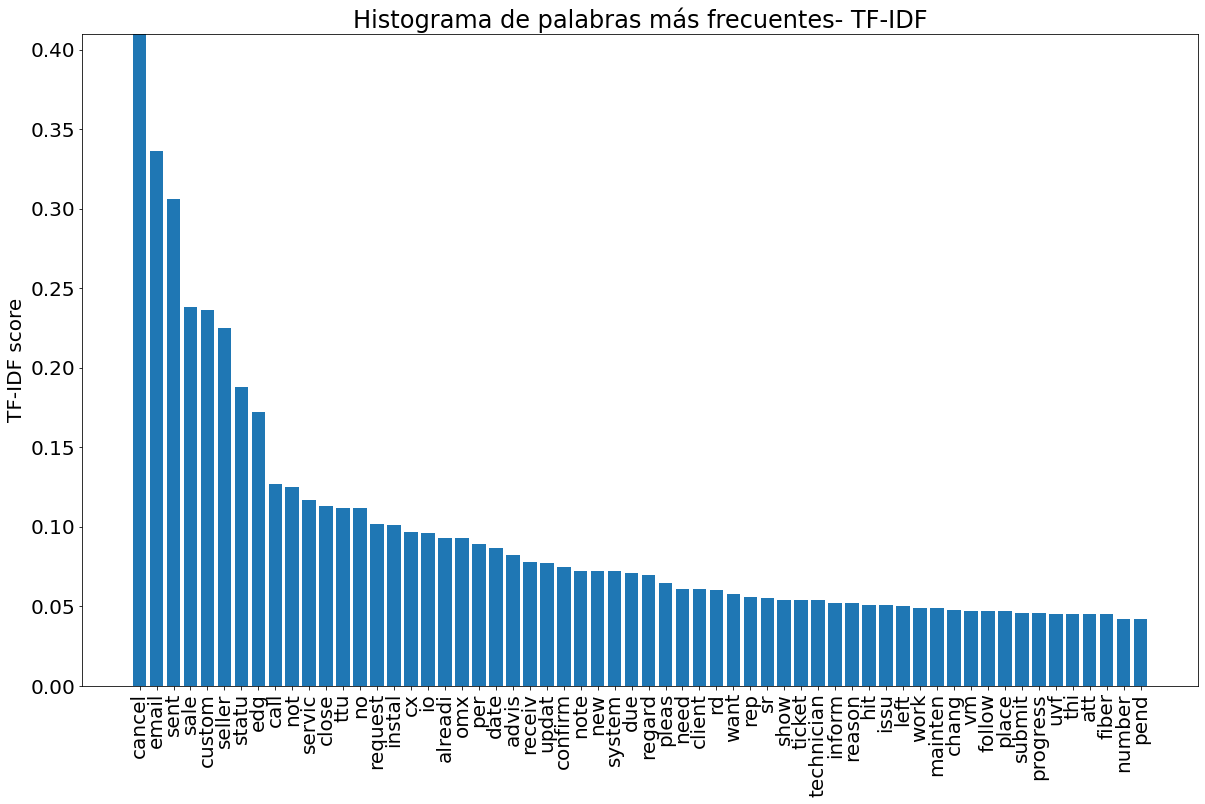

In [53]:
# Crear el histograma perspectiva 1 (palabras simples)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(20,12))
palabras = [a_tuple[0] for a_tuple in tuple_listax]
frecuencias = [a_tuple[1] for a_tuple in tuple_listax]
plt.bar(palabras[0:60],frecuencias[0:60])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF score')
plt.title('Histograma de palabras más frecuentes- TF-IDF')
plt.ylim(0,0.41)

Las tres palabras mas frecuentes son cancel, email y sent. Esto puede estar haciendo referencia por un lado al estatus final de la orden antes de cerrar y por otro al proceso de enviar correos. Esto ultimo puede ser preocupante pues este proceso debe ser registrado de una forma diferente en el sistema, por lo que tambien deberá hacerse un reentrenamiento a los agentes que manejan las ordenes.

Por otro lado, tambien se puede ver que la herramienta más mencionada es edge, seguido de ios, omx y rds. Estas son herramientas que se usan dentro del proceso para solicitar tecnicos, validar datos de instalación, etc. Esto es relevante ya que indica que los agentes estan haciendo uso de dichas herramientas y que son interacciones que normalmente no quedan en el sistema con los protocolos actuales.

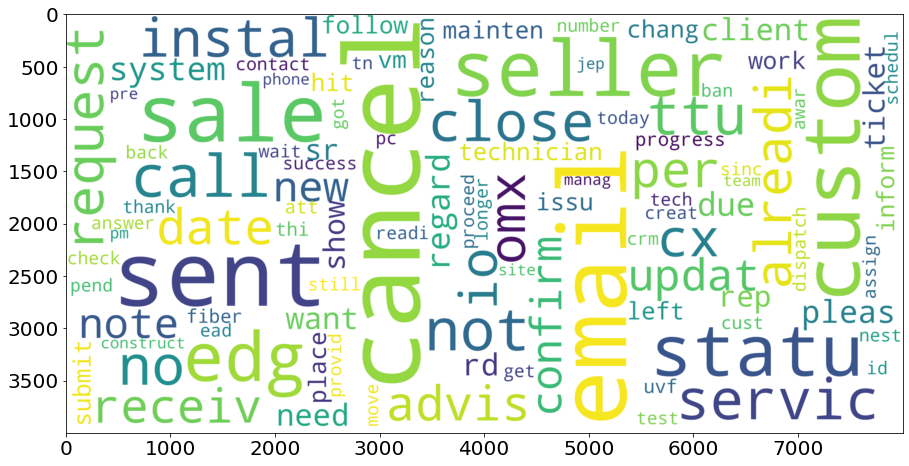

In [54]:
#from PIL import Image
#import matplotlib.pyplot as plt
#wc = WordCloud(background_color="white",width=1000,height=1000, max_words=10,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dictionary)
#plt.imshow(wc)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate_from_frequencies(keywords)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
plt.show()

Es importante tener en cuenta que tras realizar el proceso de lemmantizacion y Stemming, la palabra "completado" dejó de aparecer en la nube de palabra. Probablemente tenga que ver con que el 70% de las ordenes estén completadas y que en el último comentario diario que realiza el agente, se incluye el estado final de la orden.

Por otro lado, se puede observar que en las 100 palabras mas frecuentes aparecen temas de cancelación, instalación, correos, problemas, requerimientos, menciones al vendedor y al cliente. También podemos ver que hay mención a herramientas especificas y a procesos. 

# Bigrams

In [55]:
import time
start_time = time.time()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
cv=CountVectorizer(stop_words=stop_words,max_features=10000,ngram_range = (2,2))
word_count_vector=cv.fit_transform(docs)
print("---El tiempo para proceso de vectorizacion bigrams fue de :%s seconds ---" % (time.time() - start_time))

---El tiempo para proceso de vectorizacion bigrams fue de :0.19015908241271973 seconds ---


In [56]:
# Calcular los IDF values. we are essentially taking the sparse matrix from CountVectorizer (word_count_vector) 
#to generate the IDF when you invoke tfidf_transformer.fit(...)
import time
start_time = time.time()
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
print("---El tiempo para aplicar tfidf sobre bigrams fue: :%s seconds ---" % (time.time() - start_time))


---El tiempo para aplicar tfidf sobre bigrams fue: :0.002196788787841797 seconds ---


In [57]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """Obtener los feature names y el tf-idf score de las top n palabras"""
    
    #Para este caso se usa solo el top n de items para el vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # Indice de palabras correspondiente al tf_idf score
    for idx, score in sorted_items:
        
        #Esto es para mantener el orden entre el feature y el score correspondiente
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #Crear las tuplas de  feature,score
    #resultados = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [58]:
import time
start_time = time.time()
from scipy.sparse import coo_matrix
# Esta parte es para crear el mapping index solo una vez 
feature_names=cv.get_feature_names()

# Crear o seleccionar el documento sobre el que queremos extraer las keyword
doc=str(docs[0:273787])

#generar el tf-idf para el documento
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#Ordenar los vectores tf-idf vectors en orden descendente de acuerdo al score
sorted_items=sort_coo(tf_idf_vector.tocoo())

#Extraer el top n de palabras
keywords=extract_topn_from_vector(feature_names,sorted_items,100)

print("---El tiempo para obtener las 100 bigrams de mayor tfidf fue: :%s seconds ---" % (time.time() - start_time))


---El tiempo para obtener las 100 bigrams de mayor tfidf fue: :0.1450645923614502 seconds ---


In [59]:
# Convertir a tupla
tuplex = keywords.items()
tuple_listax = list(tuplex)
tuple_listax=sorted(tuple_listax, key = lambda x: x[1], reverse=True)
tuple_listax

[('order complet', 0.382),
 ('email sent', 0.318),
 ('complet order', 0.272),
 ('order cancel', 0.246),
 ('cancel order', 0.218),
 ('complet email', 0.208),
 ('sent sale', 0.192),
 ('complet edg', 0.176),
 ('statu complet', 0.174),
 ('edg email', 0.164),
 ('sent seller', 0.149),
 ('email sale', 0.122),
 ('close order', 0.121),
 ('sale order', 0.116),
 ('order order', 0.108),
 ('seller order', 0.096),
 ('sent complet', 0.094),
 ('complet sent', 0.088),
 ('cancel email', 0.087),
 ('ttu complet', 0.085),
 ('sent email', 0.085),
 ('complet io', 0.084),
 ('order statu', 0.077),
 ('complet statu', 0.075),
 ('sale rep', 0.073),
 ('regard order', 0.073),
 ('sent sr', 0.071),
 ('sr regard', 0.07),
 ('complet seller', 0.067),
 ('edg note', 0.065),
 ('seller custom', 0.064),
 ('complet complet', 0.06),
 ('custom advis', 0.058),
 ('pleas cancel', 0.056),
 ('custom cancel', 0.054),
 ('cancel statu', 0.053),
 ('advis order', 0.053),
 ('request cancel', 0.053),
 ('complet ttu', 0.052),
 ('order recei

(0.0, 0.4)

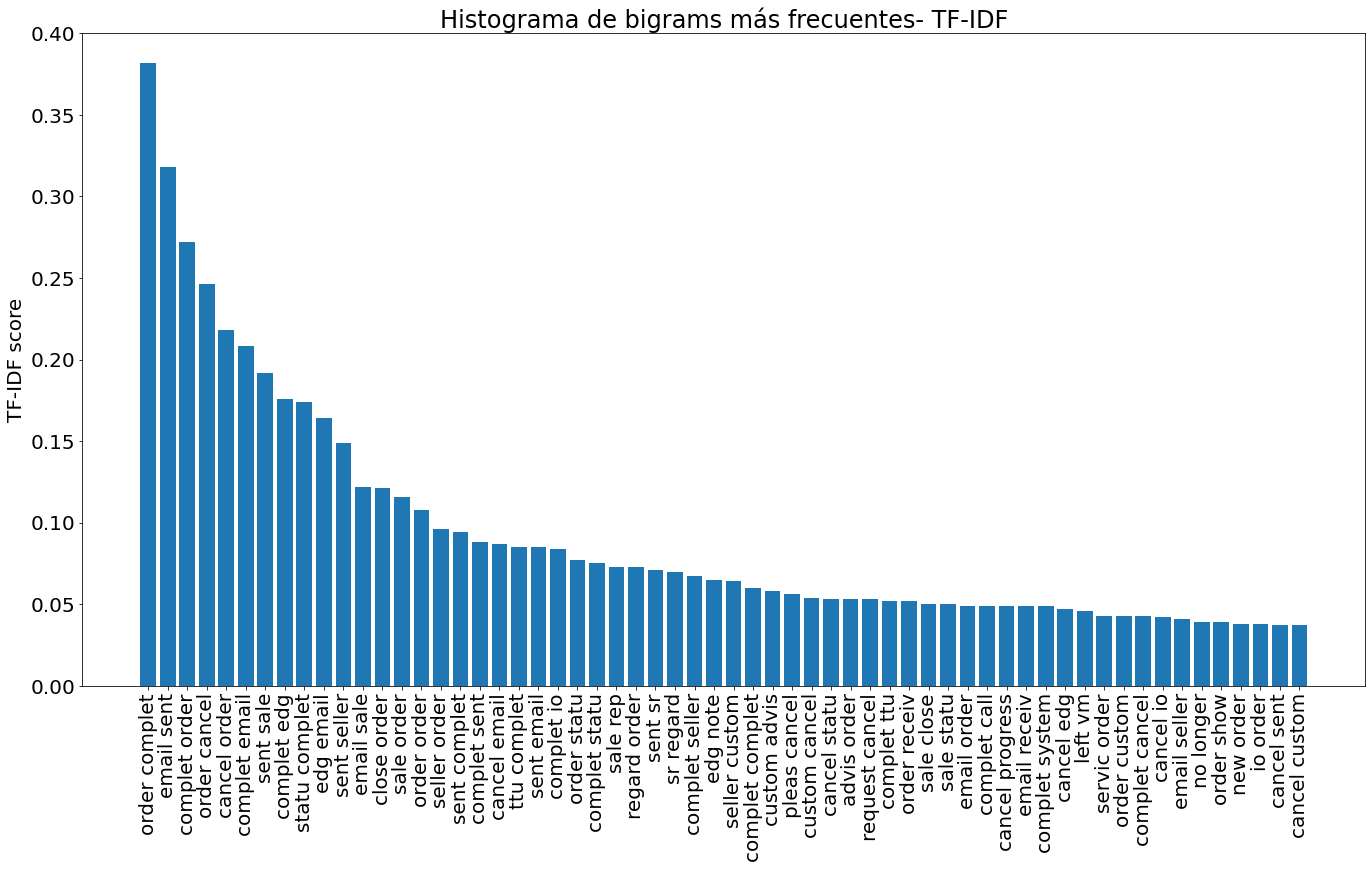

In [62]:
# Crear el histograma perspectiva 1 (palabras simples)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(23,12))
palabras = [a_tuple[0] for a_tuple in tuple_listax]
frecuencias = [a_tuple[1] for a_tuple in tuple_listax]
plt.bar(palabras[0:60],frecuencias[0:60])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF score')
plt.title('Histograma de bigrams más frecuentes- TF-IDF')
plt.ylim(0,0.4)

En el análisis de Bigramas se puede observar que hay muchos de ellos que incluyen las palabras asociadas a envio de comunicaciones o bien hacia el vendedor o hacia el customer. Esto es de interés pues en el sistema hay codificaciones para registrar este tipo de interacciones y esto indica que los agentes no las están usando adecuadamente. 

Por otro lado se puede observar que mencionan el uso de ciertas herramientas del proveedor de internet, que no estan tipificadas dentro de las interacciones. 

Adicionalmente, aparecen algunos indicadores que denotan que ciertos procesos se han hecho y que claramente estan asociados con la completitud de la instalación del servicio. Por ejemplo, TTU completed.

(0.0, 0.4)

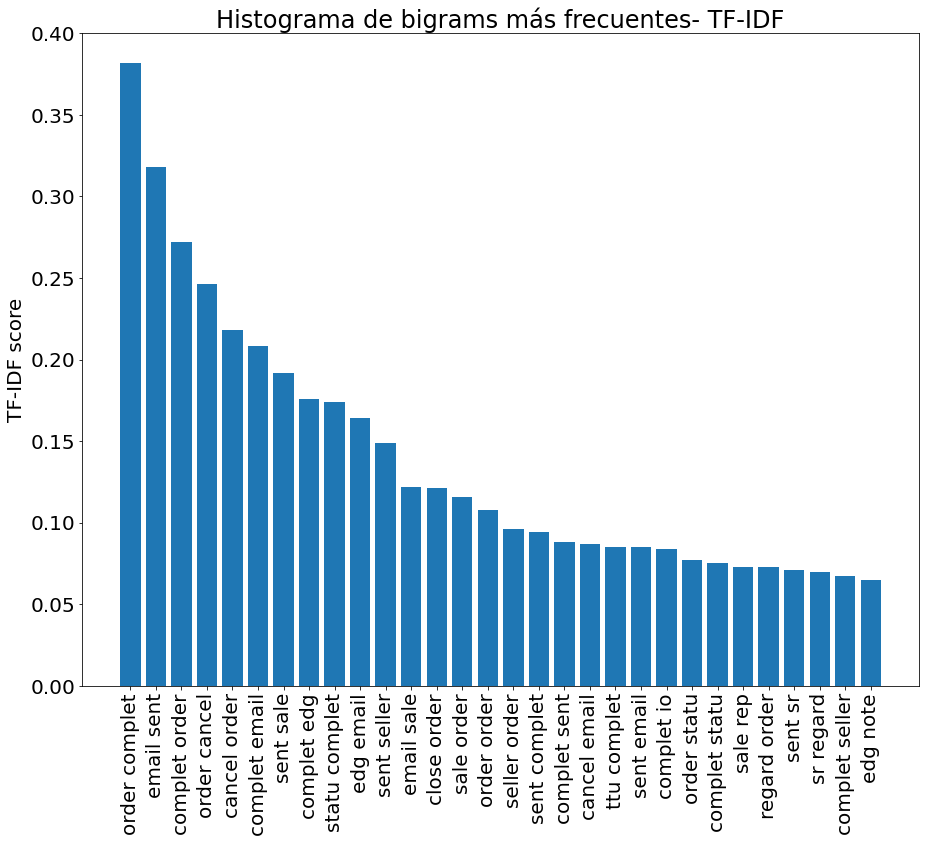

In [63]:
# Crear el histograma perspectiva 1 (palabras simples)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(15,12))
palabras = [a_tuple[0] for a_tuple in tuple_listax]
frecuencias = [a_tuple[1] for a_tuple in tuple_listax]
plt.bar(palabras[0:30],frecuencias[0:30])
plt.xticks(rotation=90)
plt.ylabel('TF-IDF score')
plt.title('Histograma de bigrams más frecuentes- TF-IDF')
plt.ylim(0,0.4)

# **Buscar Bigrams en el texto**

In [85]:
%%time
def devuelve_indicador_bigrams(bigrams,data_frame):
  pat = '|'.join(" ".join(x) for x in bigrams)
  new_df = df.event2_lem2.str.findall(pat)
  final_df=new_df.str.join(',').str.get_dummies(sep=',')
  final_df['event']=df.event

bigrams = [('order', 'complet'),('complet', 'edg'),('email', 'sent'),('closing', 'order'),('complet','email'),('complet','order'),
           ('ttu', 'complet'),('complet', 'io'),('pleas', 'cancel'),('advis', 'order'),('customer', 'advis'),
           ('edg','note'),('complet','seller')]
devuelve_indicador_bigrams(bigrams,df)

CPU times: user 57.1 ms, sys: 0 ns, total: 57.1 ms
Wall time: 57.2 ms


In [86]:
pat = '|'.join(" ".join(x) for x in bigrams)

In [87]:
new_df = df.event2_lem2.str.findall(pat)

In [88]:
#final_df.tail(30)
devuelve_indicador_bigrams(bigrams,df)

In [89]:
final_df=new_df.str.join(',').str.get_dummies(sep=',')

In [90]:
final_df

,advis order,complet edg,complet email,complet io,complet order,complet seller,edg note,email sent,order complet,pleas cancel,ttu complet
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,1,0,0,0,0,0
10235,0,0,0,0,0,0,0,0,0,0,0
10236,0,0,0,0,0,0,0,0,0,0,0
10237,0,0,0,0,0,0,0,0,1,0,0


Se agrega el campo de evento original a la busqueda de bigrams.

Posteriormente se muestran algunas frecuencias de bigrams en el texto general. en donde se puede observar por ejemplo que "order complet" aparece en mas de 2000 casos de los 10.000 que se están trabajando. El bigram "email sent" aparece en poco mas de mil casos. El bigram 'complet email' aparece en menos de mil casos de los empleados para el analisis. El resto de los Bigrams parecen hacer referencia a situaciones particulares por lo que su frecuencia llega a ser mucho menor a 1000 (o el 10%)

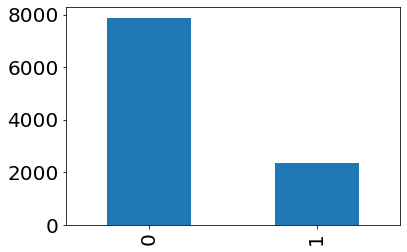

In [76]:
final_df['order complet'].value_counts().plot.bar()


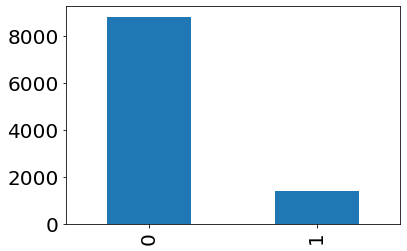

In [91]:
final_df['email sent'].value_counts().plot.bar()

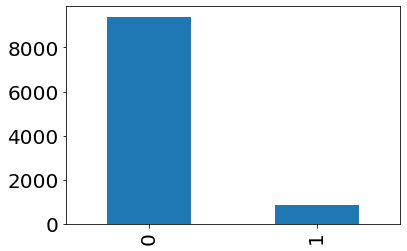

In [83]:
final_df['complet email'].value_counts().plot.bar()

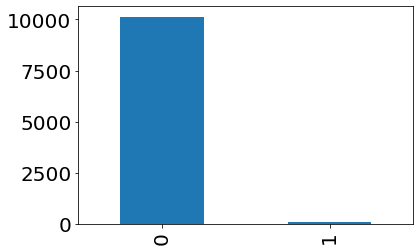

In [92]:
final_df['complet order'].value_counts().plot.bar()

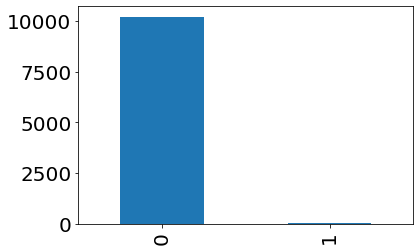

In [74]:
final_df['advis order'].value_counts().plot.bar()

In [93]:
  final_df['event']=df.event

In [94]:
final_df

,advis order,complet edg,complet email,complet io,complet order,complet seller,edg note,email sent,order complet,pleas cancel,ttu complet,event
0,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Order has been fully cancel...
1,0,0,0,0,0,0,0,0,0,1,0,"Day Summary Notes/ ""CANCEL"", Email received fr..."
2,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Job ID issue
3,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Still no updates
4,0,0,0,0,0,0,0,0,1,0,0,Day Summary Notes/ order completed
...,...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,1,0,0,0,0,0,Day Summary Notes/ Completed: Seller and custo...
10235,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ dispatch
10236,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Jeanette scheduled install ...
10237,0,0,0,0,0,0,0,0,1,0,0,Day Summary Notes/ order completed.


In [95]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10239 entries, 0 to 10238
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   advis order     10239 non-null  int64 
 1   complet edg     10239 non-null  int64 
 2   complet email   10239 non-null  int64 
 3   complet io      10239 non-null  int64 
 4   complet order   10239 non-null  int64 
 5   complet seller  10239 non-null  int64 
 6   edg note        10239 non-null  int64 
 7   email sent      10239 non-null  int64 
 8   order complet   10239 non-null  int64 
 9   pleas cancel    10239 non-null  int64 
 10  ttu complet     10239 non-null  int64 
 11  event           10239 non-null  string
dtypes: int64(11), string(1)
memory usage: 1.3 MB


# **Entrenamiento de los datos**


En este apartado se creará un modelo XGBOOST que permita predecir si la orden se cancela o no, tomando en cuenta las palabras extraidas luego del proceso de anterior descrito. 

In [97]:
df.shape

(10239, 22)

In [98]:
df2 = pd.merge(df, final_df, left_index=True, right_index=True)

In [99]:
df2

,order_id,project_status_name,closed_date,cancelcodes,prodreclass,dur,experience,experience_seller,pm_seller_exp,cc,uc,oc,totalcalls,month,year,status,event_x,event_description,interaction_date,event2,event2_lem,event2_lem2,advis order,complet edg,complet email,complet io,complet order,complet seller,edg note,email sent,order complet,pleas cancel,ttu complet,event_y
0,1016077201,Cancelled,2020-06-09 09:49:00,CancelPos-CxNoLongerWants,ADI,13,249,21,2,0,0,0,1,6,2020,Cancelled,Day Summary Notes/ Order has been fully cancel...,Day Summary Notes/ Order has been fully cancel...,2020-06-09 09:52:41.000,order fully canceled closed order,"[order, fully, canceled, closed, order]",order fulli cancel close order,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Order has been fully cancel...
1,4248728235,Cancelled,2020-06-16 18:55:00,CancelPre-ReceivedCancel,ABF,2,649,22,12,0,0,1,1,6,2020,Invalid,"Day Summary Notes/ ""CANCEL"", Email received fr...","Day Summary Notes/ ""CANCEL"", Email received fr...",2020-06-11 15:22:01.000,cancel email received seller can please c...,"[cancel, email, received, seller, can, please,...",cancel email receiv seller can pleas cancel or...,0,0,0,0,0,0,0,0,0,1,0,"Day Summary Notes/ ""CANCEL"", Email received fr..."
2,4167403019,Cancelled,2020-05-19 12:20:00,Cancel-ReorderSysIssue,ABF,20,128,32,1,<NA>,<NA>,<NA>,<NA>,5,2020,Invalid,Day Summary Notes/ Job ID issue,Day Summary Notes/ Job ID issue,2020-05-15 14:28:54.000,job id issue,"[job, id, issue]",job id issu,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Job ID issue
3,4093100504,Completed,2020-10-15 11:05:00,,ABF,209,335,54,21,3,1,0,4,10,2020,Completed,Day Summary Notes/ Still no updates,Day Summary Notes/ Still no updates,2020-10-09 12:01:32.000,still no updates,"[still, no, update]",still no updat,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Still no updates
4,1016559027,Completed,2020-10-16 19:32:00,,ADI,99,179,31,1,3,2,0,5,10,2020,Completed,Day Summary Notes/ order completed,Day Summary Notes/ order completed,2020-10-16 19:32:43.820,order completed,"[order, completed]",order complet,0,0,0,0,0,0,0,0,1,0,0,Day Summary Notes/ order completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10234,1016623582,Completed,2020-10-02 17:37:00,,ADI,70,348,7,6,2,0,0,4,10,2020,Completed,Day Summary Notes/ Completed: Seller and custo...,Day Summary Notes/ Completed: Seller and custo...,2020-10-02 17:48:51.000,completed seller customer advised,"[completed, seller, customer, advised]",complet seller custom advis,0,0,0,0,0,1,0,0,0,0,0,Day Summary Notes/ Completed: Seller and custo...
10235,6102459355,Completed,2020-12-29 15:07:00,,ABF,14,130,22,1,0,2,0,2,12,2020,Completed,Day Summary Notes/ dispatch,Day Summary Notes/ dispatch,2020-12-28 10:42:57.970,dispatch,[dispatch],dispatch,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ dispatch
10236,5432821792,Completed,2020-07-03 16:38:00,,ABF,109,384,30,12,0,0,2,2,7,2020,Completed,Day Summary Notes/ Jeanette scheduled install ...,Day Summary Notes/ Jeanette scheduled install ...,2020-06-30 17:19:41.000,jeanette scheduled install,"[jeanette, scheduled, install]",jeanett schedul instal,0,0,0,0,0,0,0,0,0,0,0,Day Summary Notes/ Jeanette scheduled install ...
10237,1017480960,Completed,2020-10-16 14:14:00,,ADI,8,519,13,2,1,0,0,1,10,2020,Completed,Day Summary Notes/ order completed.,Day Summary Notes/ order completed.,2020-10-16 14:19:42.000,order completed,"[order, completed]",order complet,0,0,0,0,0,0,0,0,1,0,0,Day Summary Notes/ order completed.


In [100]:
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

En este codigo se muestran las columnas que tiene el dataset para seleccionar las que se usarán en el modelo como variables independientes. 

In [101]:
df2.columns

Index(['order_id', 'project_status_name', 'closed_date', 'cancelcodes',
       'prodreclass', 'dur', 'experience', 'experience_seller',
       'pm_seller_exp', 'cc', 'uc', 'oc', 'totalcalls', 'month', 'year',
       'status', 'event_x', 'event_description', 'interaction_date', 'event2',
       'event2_lem', 'event2_lem2', 'advis order', 'complet edg',
       'complet email', 'complet io', 'complet order', 'complet seller',
       'edg note', 'email sent', 'order complet', 'pleas cancel',
       'ttu complet', 'event_y'],
      dtype='object')

Debido a que XGBOOST necesita que la variable objetivo este categorizada en números, se definen a continuación los status, de modo que 1 sea Cancelado y 0 Completado.

In [102]:
# to numerical
mappings = {'Completed':0, 'Cancelled':1, 'Invalid':1}
df2['status2'] = df2.status.replace(mappings, inplace = True)

Se hace un reemplazo de valores nulos por cero. Esta será la unica limpieza para este ejercicio pues la data viene de SQL donde se almacena luego de un proceso de estandarización. 

In [103]:
df2 = df2.fillna(0)

In [104]:
df2.groupby('status').size()

status
0    6365
1    3874
dtype: int64

Es importante tener en consideracion la cantidad de casos que se encuentran en cada categoria de la variable objetivo, de modo que se pueda hacer un balanceo de las categorías si estan llegasen a estar disparejas. En este caso vemos que el 62% de las ordenes utilizadas para el modelo se encuentran completadas, mientras que el 38% canceladas. Este desbalance podria ocasionar problemas de training, pero se realizará primero un análisis para validar los resultados.


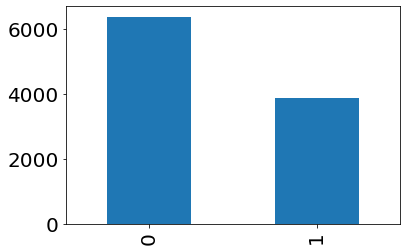

In [105]:
df2['status'].value_counts().plot.bar()

En esta sección se definen las columnas que formarán parte del training

In [106]:
x1 = df2[['advis order','complet edg','complet io','email sent', 'order complet', 'pleas cancel',	'ttu complet','complet email','complet order',
          'complet seller','edg note']] #,'dur','experience','experience_seller','pm_seller_exp', 'cc', 'uc', 'oc', 'totalcalls']]


In [107]:
x1

,advis order,complet edg,complet io,email sent,order complet,pleas cancel,ttu complet,complet email,complet order,complet seller,edg note
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10234,0,0,0,0,0,0,0,0,0,1,0
10235,0,0,0,0,0,0,0,0,0,0,0
10236,0,0,0,0,0,0,0,0,0,0,0
10237,0,0,0,0,1,0,0,0,0,0,0


A continuación se definen la variable objetivo con las dos categorias: completado y cancelado

In [108]:
y1 = df2['status']

Luego se definen las características del modelo a realizar, en donde se selecciona un arbol de profundidad 7 niveles, una tasa de aprendizaje de 0.4 y la metrica de evaluacion logloss. Esta funcion de clasificacion cuenta el precio que se paga por imprecisiones en la clasificacion teniendo en cuenta la probabiliad de clasificacion. De esta forma, penaliza las clasificaciones falsas al tener en cuenta su probabilidad. 

In [109]:
xgboostmodel = xgb.XGBClassifier(max_depth=7,n_estimators=500,learning_rate=0.4,n_jobs=-1,eval_metric=["logloss"], use_label_encoder=False, subsample=1, scale_pos_weight=3) # Set model properties

Posteriormente se definen las muestras de entrenamiento y validación con un 80% y 20% respectivamente.

In [110]:
Xabf_train, Xabf_test, Yabf_train, Yabf_test = train_test_split(x1,y1, test_size=0.2, random_state=0) #set partition

In [111]:
eval_setabf = [(Xabf_test, Yabf_test)] #set partition

In [112]:
Xabf_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 3991 to 2732
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   advis order     8191 non-null   int64
 1   complet edg     8191 non-null   int64
 2   complet io      8191 non-null   int64
 3   email sent      8191 non-null   int64
 4   order complet   8191 non-null   int64
 5   pleas cancel    8191 non-null   int64
 6   ttu complet     8191 non-null   int64
 7   complet email   8191 non-null   int64
 8   complet order   8191 non-null   int64
 9   complet seller  8191 non-null   int64
 10  edg note        8191 non-null   int64
dtypes: int64(11)
memory usage: 767.9 KB


Finalmente se realiza el entrenamiento del modelo con los datos recopilados y las caracteristicas indicadas.

In [113]:
xgboostmodel.fit(Xabf_train,Yabf_train,eval_metric=["logloss"], eval_set=eval_setabf, early_stopping_rounds=10, verbose=True) #Train the model

[0]	validation_0-logloss:0.550963
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.503089
[2]	validation_0-logloss:0.485654
[3]	validation_0-logloss:0.479863
[4]	validation_0-logloss:0.478422
[5]	validation_0-logloss:0.477653
[6]	validation_0-logloss:0.477251
[7]	validation_0-logloss:0.476427
[8]	validation_0-logloss:0.475822
[9]	validation_0-logloss:0.475067
[10]	validation_0-logloss:0.474509
[11]	validation_0-logloss:0.474265
[12]	validation_0-logloss:0.474002
[13]	validation_0-logloss:0.473959
[14]	validation_0-logloss:0.473812
[15]	validation_0-logloss:0.47379
[16]	validation_0-logloss:0.473717
[17]	validation_0-logloss:0.473718
[18]	validation_0-logloss:0.473735
[19]	validation_0-logloss:0.473761
[20]	validation_0-logloss:0.473698
[21]	validation_0-logloss:0.473736
[22]	validation_0-logloss:0.473716
[23]	validation_0-logloss:0.473733
[24]	validation_0-logloss:0.473704
[25]	validation_0-logloss:0.473736
[26]	validation_0-logloss:0.47367

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric=['logloss'],
              gamma=0, learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

El Log loss de la ultima iteración fue de 0.47. 

# **Resultados**

La precisión de la partición de entrenamiento y prueba fue de 77%. A nivel general esto es positivo pues podria estar indicando que el modelo se comportará de la misma forma que el entrenamiento pero con datos nuevos o diferentes al de entrenamiento.
Adicionalmente, la precisión global al ser de 77% resulta adecuada.

In [114]:
accuracy_score(Yabf_train,xgboostmodel.predict(Xabf_train))

0.778903674764986

In [115]:
accuracy_score(Yabf_test,xgboostmodel.predict(Xabf_test))

0.7744140625

Posteriormente se procede a realizar la matriz de clasificación del modelo para ambas particiones, encontrrando que los porcentajes se parecen mucho. Esepecificamente, el acierto para la categoria Cancelado (1) es de 99% en ambos modelos, mientras que para la categoria Completado (0) oscila entre 64% y 65%. Esto tambien indica que la precisión que se mantiene entre particiones persiste entre las diferentes categorias modeladas.

In [116]:
matrixtrainabf= confusion_matrix(Yabf_train,xgboostmodel.predict(Xabf_train))
matrixtestabf= confusion_matrix(Yabf_test,xgboostmodel.predict(Xabf_test))

In [117]:
matrixtrainabf = pd.DataFrame(matrixtrainabf)
matrixtrainabf['Acc1']= matrixtrainabf[0] / (matrixtrainabf[0] + matrixtrainabf[1])
matrixtrainabf['Acc2']= matrixtrainabf[1] / (matrixtrainabf[0] + matrixtrainabf[1])
matrixtrainabf

,0,1,Acc1,Acc2
0,3312,1781,0.650304,0.349696
1,30,3068,0.009684,0.990316


Llama la atención la diferencia marcada entre las categorias 0 y 1, pues son contrarias al desbalance visto anteriormente. Es por esto que se puede tener como hipotesis que la diferencia marcada entre la precisión de las categorias puede deberse a las variables empleadas mas que al imbalance inicial. Esto puede deberse a que los bigrams empleados puedan tener mas relacion con las cancelaciones que con que una orden se pueda completar normalmente. 

In [118]:
matrixtestabf = pd.DataFrame(matrixtestabf)
matrixtestabf['Acc1']= matrixtestabf[0] / (matrixtestabf[0] + matrixtestabf[1])
matrixtestabf['Acc2']= matrixtestabf[1] / (matrixtestabf[0] + matrixtestabf[1])
matrixtestabf

,0,1,Acc1,Acc2
0,817,455,0.642296,0.357704
1,7,769,0.009021,0.990979


Finalmente, se observa que de las 11 columnas empleadas, las mas importantes que se pueden ver en el gráfico siguiente fueron complet edg, order complet, edg note y email sent. Esto puede tener sentido pues edge es el principal sistema donde se encuentran las ordenes, y es donde el proveedor de servicios de interner marca la orden como instalada o completada, indicando su estatus final para su cierre. En ocasiones, la orden puede cerrarse antes que el agente lo note, sobretodo si hay problemas tecnicos o el vendedor asi lo decide (esto puede suceder sobretodo con las canceladas).

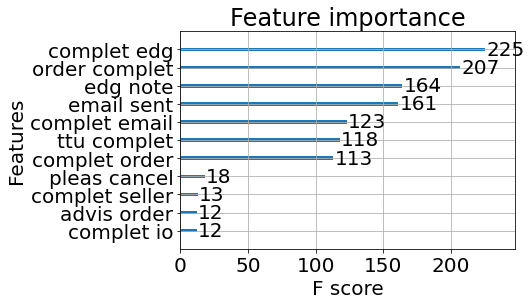

In [119]:
xgb.plot_importance(xgboostmodel, max_num_features=20)

In [ ]:
df_grouped_by = df2.groupby(['status'])
df_grouped_by

Finalmente, como forma de validar si existe overfitting en el modelo, se realiza un XGBOOST con diferentes muestras usando Kfold = 5. Tras esto se encuentra el mismo % de precisión visto en los calculos anteriores, es decir, 77% de acierto. 

In [122]:
kfold = KFold(n_splits=5)
resultsabf = cross_val_score(xgboostmodel, x1, y1, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (resultsabf.mean()*100, resultsabf.std()*100))

Accuracy: 77.83% (0.68%)


# **Conclusiones y Recomendaciones**

Tras realizar el análisis propuesto se puede consluir que el análisis de NLP s es util para detectar agentes que no estan siguiendo el debido proceso de registro de información en el sistema, situaciones que ocurren y que no estan estandarizadas en el sistema y detectar el uso de herramientas especificas en el ciclo de vida de la orden. Adicionalmente, se puede concluir que las palabras que proceden de este análisis pueden servir para predecir la probabilidad de que una orden se cancele con una buena precisión. 

Por otro lado, luego de realizar el análisis se recomiendan las siguientes acciones:


1.   Unificar bigramas que denotan la misma accion del agente, como lo son enviar un correo al vendedor. Esto permitiria ver otras ocurrencias frecuentes con significado diferente.
2.   Reemplazar o corregir ortograficamente la forma en que se escriben algunas palabras de relevancia, como por ejemplo, cambiar cx por customer.
3.  Incluir unigramas que puedan ser relevantes para el análisis (según criterio de negocio, podrian considerarse comentarios que indiquen que falta una dirección (missing), que no haya comunicación (unresponsive) o que haya problemas con la orden (issues).
4. Entrenar el modelo con el resto de las ordenes.
5. Usar otras variables para abarcar ordenes que no tengan comentarios de los agentes.


